<a href="https://colab.research.google.com/github/madonnaojorin/MAT494/blob/main/3.5_K_means_3.6_Support_Vector_Machine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#3.5 K-means

In [2]:
#!pip install  kneed

In [3]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [4]:
features, true_labels = make_blobs(
    n_samples=200,
    centers=3,
    cluster_std=2.75,
    random_state=42
    )

In [5]:
features[:5]

array([[  9.77075874,   3.27621022],
       [ -9.71349666,  11.27451802],
       [ -6.91330582,  -9.34755911],
       [-10.86185913, -10.75063497],
       [ -8.50038027,  -4.54370383]])

In [6]:
true_labels[:5]

array([1, 0, 2, 2, 2])

In [7]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [8]:
scaled_features[:5]

array([[ 2.13082109,  0.25604351],
       [-1.52698523,  1.41036744],
       [-1.00130152, -1.56583175],
       [-1.74256891, -1.76832509],
       [-1.29924521, -0.87253446]])

In [9]:
kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42
    )

In [10]:
kmeans.fit(scaled_features)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=3,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=42,
       tol=0.0001, verbose=0)

In [11]:
kmeans.inertia_

74.57960106819854

In [12]:
kmeans.cluster_centers_

array([[ 1.19539276,  0.13158148],
       [-0.25813925,  1.05589975],
       [-0.91941183, -1.18551732]])

In [13]:
kmeans.n_iter_

6

In [14]:
kmeans.labels_[:5]

array([0, 1, 2, 2, 2], dtype=int32)

In [15]:
 kmeans_kwargs = {
     "init": "random",
      "n_init": 10,
      "max_iter": 300,
      "random_state": 42,
       }
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(scaled_features)
  sse.append(kmeans.inertia_)

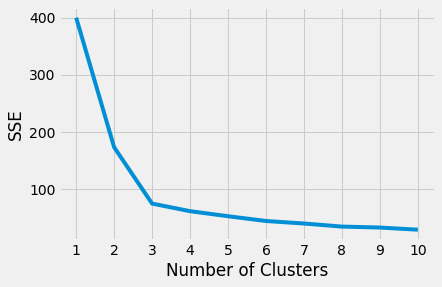

In [16]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [17]:
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
    )

In [18]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(scaled_features)
  score = silhouette_score(scaled_features, kmeans.labels_)
  silhouette_coefficients.append(score)

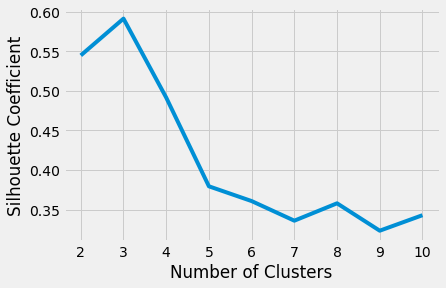

In [19]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

#3.6 Support Vector Machine

### Classification

In [31]:
import numpy as np
import cvxopt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [52]:
class SVM:
  def fit(self, X, y):
        n_samples, n_features = X.shape
# P = X^T X
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = np.dot(X[i], X[j])
        P = cvxopt.matrix(np.outer(y, y) * K)
# q = -1 (1xN)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
# A = y^T 
        A = cvxopt.matrix(y, (1, n_samples))
# b = 0 
        b = cvxopt.matrix(0.0)
# -1 (NxN)
        G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
# 0 (1xN)
        h = cvxopt.matrix(np.zeros(n_samples))
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
# Lagrange multipliers
        a = np.ravel(solution['x'])
# Lagrange have non zero lagrange multipliers
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
# Intercept
        self.b = 0
        for n in range(len(self.a)):
          self.b += self.sv_y[n]
          self.b -= np.sum(self.a * self.sv_y * K[ind[n], sv])
          self.b /= len(self.a)
# Weights
        self.w = np.zeros(n_features)
        for n in range(len(self.a)):
          self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        
  def project(self, X):
      return np.dot(X, self.w) + self.b
    
    
  def predict(self, X):
      return np.sign(self.project(X))

In [53]:
X, y = make_blobs(n_samples=250, centers=2,
                  random_state=0, cluster_std=0.60)
y[y == 0] = -1
tmp = np.ones(len(X))
y = tmp * y

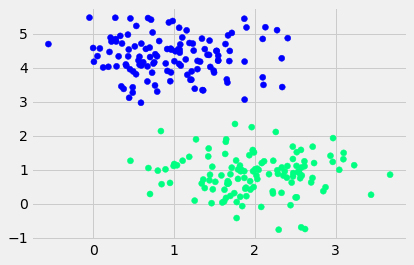

In [54]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='winter')

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [56]:
svm = SVM()
svm.fit(X_train, y_train)

     pcost       dcost       gap    pres   dres
 0: -1.8226e+01 -3.4458e+01  6e+02  2e+01  2e+00
 1: -2.5252e+01 -1.8773e+01  2e+02  9e+00  7e-01
 2: -5.3459e+01 -3.2711e+01  2e+02  7e+00  6e-01
 3: -7.8360e+01 -2.6482e+01  1e+02  4e+00  3e-01
 4: -5.6818e+00 -5.1750e+00  1e+01  2e-01  1e-02
 5: -3.6906e+00 -4.1082e+00  4e-01  4e-16  9e-15
 6: -4.0061e+00 -4.0104e+00  4e-03  1e-15  6e-15
 7: -4.0094e+00 -4.0094e+00  4e-05  1e-15  4e-15
 8: -4.0094e+00 -4.0094e+00  4e-07  2e-15  7e-15
Optimal solution found.


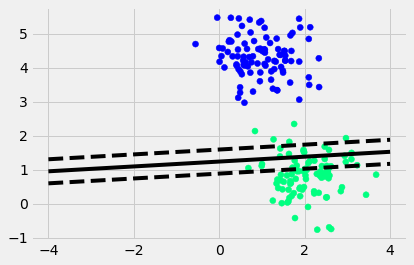

In [57]:
def f(x, w, b, c=0):
    return (-w[0] * x - b + c) / w[1]
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='winter')
# w.x + b = 0
a0 = -4; a1 = f(a0, svm.w, svm.b)
b0 = 4; b1 = f(b0, svm.w, svm.b)
plt.plot([a0,b0], [a1,b1], 'k')
# w.x + b = 1
a0 = -4; a1 = f(a0, svm.w, svm.b, 1)
b0 = 4; b1 = f(b0, svm.w, svm.b, 1)
plt.plot([a0,b0], [a1,b1], 'k--')
# w.x + b = -1
a0 = -4; a1 = f(a0, svm.w, svm.b, -1)
b0 = 4; b1 = f(b0, svm.w, svm.b, -1)
plt.plot([a0,b0], [a1,b1], 'k--')

In [58]:
y_pred = svm.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[29,  0],
       [ 7, 27]])

In [59]:
svc = LinearSVC()
svc.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

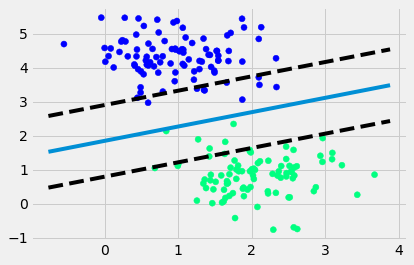

In [60]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='winter');
ax = plt.gca()
xlim = ax.get_xlim()
w = svc.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(xlim[0], xlim[1])
yy = a * xx - svc.intercept_[0] / w[1]
plt.plot(xx, yy)
yy = a * xx - (svc.intercept_[0] - 1) / w[1]
plt.plot(xx, yy, 'k--')
yy = a * xx - (svc.intercept_[0] + 1) / w[1]
plt.plot(xx, yy, 'k--')

In [61]:
y_pred = svc.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[29,  0],
       [ 0, 34]])